# **Zero-Loss Peak Subtraction with Neural Networks**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LHCfitNikhef/CBL-ML/blob/tutorial/Tutorial/EELS_tutorial.ipynb)

## Loading the data

First of all, let us install and import all the required modules

In [1]:
!pip install ncempy

In [2]:
from ncempy.io import dm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import imageClass as EELSImage
import trainZLP as ZLPnn
#from trainZLP import train_nn_scaled

In this tutorial, we will study.....

The spectral image can be imported with the lines below

In [3]:
path_to_dm4 = 'area03-eels-SI-aligned.dm4'
im = EELSImage.Spectral_image.load_data(path_to_dm4)

## Plotting the data

Integrated intensity 2D plot + show selection

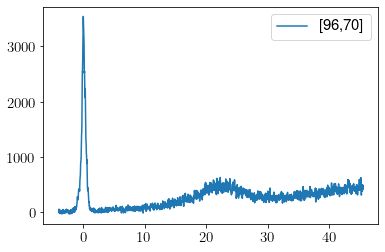

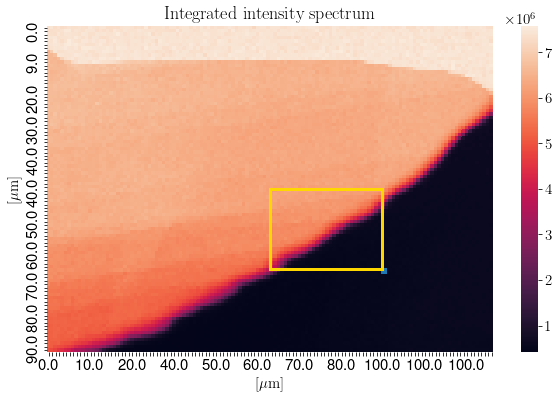

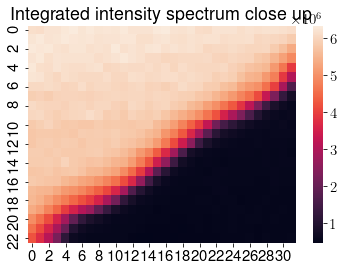

-38.748566

In [4]:
full_width, full_height = im.image_shape[1], im.image_shape[0]
loc_x, loc_y = int(0.75 * full_width), int(0.75 * full_height)
spectrum = im.plot_spectrum(loc_y, loc_x)

xmin, width = 0.5, 0.25
ymin, height = 0.5, 0.25
window = np.array([[xmin, width], [ymin, height]])
im.show_image(selection = window, pixel_highlight = [loc_x, loc_y])
spectrum.min()

## Monte Carlo replica method

Train on the replicas within a preselected cluster. One feature only: intensity. Not the integrated intensity.

## Constructing the Neural Network

In [5]:
test = np.reshape(im.data_zoomed[0,1,:], (1, -1))
ZLPnn.smooth(test)

array([[ 46.11410401,  46.70479734,  48.87989749, ..., 117.00392858,
        114.38738154, 113.47288697]])

## Smoothing

In [6]:
im.data_zoomed[-1, -2, :]

array([-24.292501 , -19.50395  ,  -4.1715503, ..., 402.20734  ,
       393.45233  , 384.0428   ], dtype=float32)

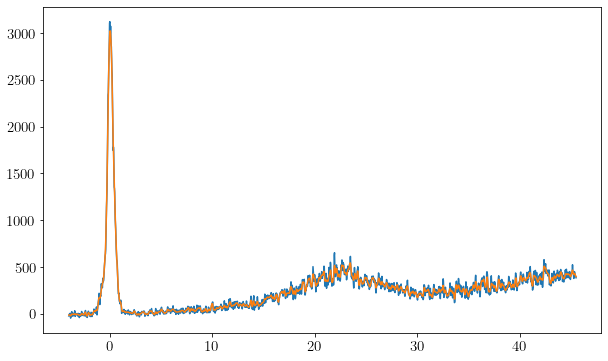

In [7]:
data_zoomed_concat = np.reshape(im.data_zoomed, (-1, im.l))
data_smooth = ZLPnn.smooth(data_zoomed_concat, window_len = 10)

plt.figure(figsize=(10,6))
plt.plot(im.deltaE, im.data_zoomed[-1, -2, :])
plt.plot(im.deltaE, data_smooth[-2,:])
plt.show()

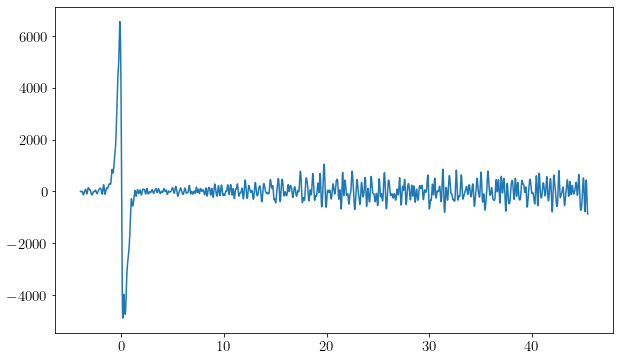

In [8]:
def der_spect(image, spectrum):
    dx = image.ddeltaE
    der_spectrum = (spectrum[:,1:]-spectrum[:,:-1])/dx
    return der_spectrum

der = der_spect(im, data_smooth)
der_smooth = ZLPnn.smooth(der, window_len = 10)

plt.figure(figsize=(10,6))
plt.plot(im.deltaE[:-1], der_smooth[-1,:])
plt.show()

## Finding $dE_1$ and $dE_2$

@Isabel: explain upper bound on dE2

In [9]:
data_avg = np.average(data_smooth, axis=0)
der_avg = np.average(der, axis=0)

dE1 = ZLPnn.find_dE1(im, der_avg, data_avg, fct=0.7)

times_dE1 = 3
min_dE2 = im.deltaE.max() - im.ddeltaE*im.l*0.05 #at least 5% zeros at end
dE2 = np.minimum(dE1 * times_dE1, min_dE2) 

In [10]:
data_zoomed_concat[-2,:]

array([-24.292501 , -19.50395  ,  -4.1715503, ..., 402.20734  ,
       393.45233  , 384.0428   ], dtype=float32)

In [11]:
dE1, dE2

(1.7850000265985726, 5.355000079795718)

In [12]:
select1 = len(im.deltaE[im.deltaE<dE1])
select2 = len(im.deltaE[im.deltaE>dE2])
select1, select2
data_zoomed_concat[:, :select1]

array([[ 65.25357  ,  33.14197  ,  37.110992 , ..., 629.01733  ,
        550.4113   , 614.3612   ],
       [ 44.606464 ,  49.52195  ,  35.697037 , ..., 514.85724  ,
        545.1694   , 533.74194  ],
       [ 94.35603  ,  28.838251 ,  86.63578  , ..., 612.1094   ,
        536.95526  , 480.36285  ],
       ...,
       [-12.069631 ,   6.153017 ,  -2.8962739, ...,  13.083566 ,
          7.769709 , -35.86243  ],
       [-24.292501 , -19.50395  ,  -4.1715503, ...,  14.981578 ,
         -3.1609008,   6.9144764],
       [ 13.36305  ,   7.0427237,  24.53474  , ...,  19.967869 ,
         17.084066 ,  12.705909 ]], dtype=float32)

## Rescaling the training data

In [13]:
def find_scale_param(inp, min_out = 0.1, max_out=0.9):
    a = (max_out - min_out)/(inp.max()- inp.min())
    b = min_out - a * inp.min()
    return [a, b]

def scale(inp, ab):
    return inp * ab[0] + ab[1]


ab_deltaE = find_scale_param(im.deltaE)
deltaE_scaled = scale(im.deltaE, ab_deltaE)


epsilon = 1e-3
data_zoomed_concat[data_zoomed_concat < 0] = epsilon

ci_low = np.nanpercentile(np.log(data_zoomed_concat), 16, axis=0)
ci_high = np.nanpercentile(np.log(data_zoomed_concat), 84, axis=0)
sigma = np.absolute(ci_high - ci_low)

## Constructing the Neural Network

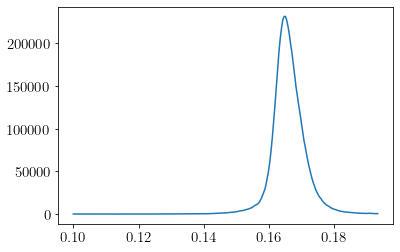

2021-05-31 22:06:44.845424 Epoch 1, Training loss 211.66656395231357
2021-05-31 22:06:45.685018 Epoch 1000, Training loss 154.44596526088716
2021-05-31 22:06:46.503347 Epoch 2000, Training loss 152.21683239369145
2021-05-31 22:06:47.327777 Epoch 3000, Training loss 152.21606788864017
2021-05-31 22:06:48.153173 Epoch 4000, Training loss 152.21355688669243
2021-05-31 22:06:48.975111 Epoch 5000, Training loss 152.1623073342281
2021-05-31 22:06:49.810177 Epoch 6000, Training loss 145.6331933923324
2021-05-31 22:06:50.638607 Epoch 7000, Training loss 119.45088816358783
2021-05-31 22:06:51.462234 Epoch 8000, Training loss 103.69115348661984
2021-05-31 22:06:52.284733 Epoch 9000, Training loss 97.00841710861656
2021-05-31 22:06:53.107712 Epoch 10000, Training loss 93.22413145458617
2021-05-31 22:06:53.922169 Epoch 11000, Training loss 90.56358501704263
2021-05-31 22:06:54.740317 Epoch 12000, Training loss 88.74187162675939
2021-05-31 22:06:55.561424 Epoch 13000, Training loss 88.2344028334821

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import datetime

class MLP(nn.Module):

    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, 10)
        self.linear2 = nn.Linear(10, 15)
        self.linear3 = nn.Linear(15, 5)
        self.output = nn.Linear(5, num_outputs)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.sigmoid(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.output(x)
        return x
    
def loss_fn(output, target, error):
    loss = torch.sum(torch.square((output - target)/error))
    return loss


def training_loop(n_rep, n_epochs, optimizer, model, loss_fn):
    for rep in range(n_rep):
        
        data_x = deltaE_scaled[:select1]
        data_y = im.data_zoomed_concat[1][:select1]
        
        plt.plot(data_x, data_y)
        plt.show()
        
        data_x = torch.tensor(data_x).unsqueeze(-1)
            
            
        data_y = torch.tensor(data_y).unsqueeze(-1)

        unc_y = im.data_unc[:select1]
        unc_y = torch.tensor(unc_y).unsqueeze(-1)
        
        for epoch in range(1, n_epochs + 1):
            loss_train = 0.0
            
            
            
            
            
            
            model_output = model(data_x.float())
            
            loss = loss_fn(model_output, data_y, unc_y)
            
            
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            loss_train += loss.item()

            if epoch == 1 or epoch % 1000 == 0:
                print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train))
        
        torch.save(model.state_dict(), './trained_nn.pt')

n_rep = im.data.shape[0] * im.data.shape[1]
n_epochs = 50000
model = MLP(num_inputs=1, num_outputs=1)
optimizer = optim.Adam(model.parameters(), lr=1e-3)                
                
training_loop(
    n_rep = 1,
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn
)

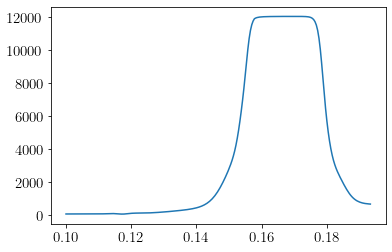

In [27]:
network_path = './trained_nn.pt'
model.load_state_dict(torch.load(network_path))

data_x = deltaE_scaled[:select1]
data_x = torch.tensor(data_x).unsqueeze(-1)

model_pred = model.forward(data_x.float())
model_pred = model_pred.detach().numpy()

plt.plot(deltaE_scaled[:select1], model_pred)
plt.show()

## Training data

In [16]:
def smooth_clusters(image, clusters, window_len = None):
    smoothed_clusters = np.zeros((len(clusters)), dtype = object)
    for i in range(len(clusters)):
        smoothed_clusters[i] = smooth(clusters[i])
    return smoothed_clusters

def derivative_clusters(image, clusters):
    dx = image.ddeltaE
    der_clusters = np.zeros((len(clusters)), dtype = object)
    for i in range(len(clusters)):
        der_clusters[i] = (clusters[i][:,1:]-clusters[i][:,:-1])/dx
    return der_clusters

def determine_dE1(image, dy_dx_clusters, y_smooth_clusters):
    dy_dx_avg = np.zeros((len(y_smooth_clusters), image.l - 1))
    dE1_clusters = np.zeros(len(y_smooth_clusters))
    for i in range(len(y_smooth_clusters)):
        dy_dx_avg[i, :] = np.average(dy_dx_clusters[i], axis=0)
        y_smooth_cluster_avg = np.average(y_smooth_clusters[i], axis=0)
        dE1_clusters[i] = find_dE1(image, dy_dx_avg[i, :], y_smooth_cluster_avg)

In [17]:
n_rep = im.data.shape[0] * im.data.shape[1]
n_epochs = 100
path_to_models = 'models/'
display_step = 100

im.train_ZLPs(data_zoomed, n_rep = n_rep,
              n_epochs = n_epochs, 
              path_to_models = path_to_models, 
              display_step = display_step)

NameError: name 'data_zoomed' is not defined

## Training the ZLP

Pretrained models

## ZLP subtraction

## Bandgap fit

In [ ]:
im.data_zoomed_concat[2].shape

In [ ]:
len(im)

In [ ]:
im[0][0].shape